In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *

In [90]:
# define parameters from the paper
# test with 170815
# bin = 8
# offset_imr = -0.0118
# theta_imr = 45
# offset_hwp = -0.002
# theta_hwp = 78.75
# theta_cal = 
# offset_cal = -0.035
# wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
                1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
                1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
                2139.4131, 2213.4641, 2290.0781, 2369.3441])
 #hwp_retardances = HWP_retardance(wavelength_bins)
# imr_retardances = IMR_retardance(wavelength_bins)
#T0D0 - ask rebecca about imperfect diattenuation of cal


IndentationError: unexpected indent (1985857215.py, line 11)

In [91]:
# create a system dict for CHARIS

def generate_CHARIS_mueller_matrix(wavelength_bin, hwp_angle, imr_angle, beam):
    """ 
    Generate a pyMuellerMuellerMat matrix object for CHARIS based on the given
    wavelength bin, HWP angle, and derotator angle. Currently only works for lowres mode. 
    Based on Joost 't Hart 2021

    Parameters:
    -----------
    wavelength_bin : int
        The index of the wavelength bin, zero based. (0 to 21 for 22 bins)
    hwp_angle : float
        The rotation angle of the half-wave plate in degrees.
    imr_angle : float
        The angle of the image rotator in degrees.
    beam : str
        The beam type, either 'o' for ordinary or 'e' for extraordinary.
    Returns:
    --------
    sys_mm : pyMuellerMat.MuellerMatrix
        A Mueller matrix object representing the CHARIS system.
    """
    # check that it is in lowres mode

    if wavelength_bin < 0 or wavelength_bin > 21:
        raise ValueError("Wavelength bin must be between 0 and 21 for lowres mode.")
    
    # constants based on Joost 't Hart 2021

    offset_imr = -0.0118 # derotator offset
    offset_hwp = -0.002 # HWP offset
    offset_cal = -0.035 # calibration polarizer offset
    wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
                1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
                1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
                2139.4131, 2213.4641, 2290.0781, 2369.3441])
    theta_imr = imr_angle
    theta_hwp = hwp_angle
    theta_cal = -45  # calibration polarizer angle
    hwp_retardances = HWP_retardance(wavelength_bins) # based on physical model
    imr_retardances = IMR_retardance(wavelength_bins) # based on physical model

    # create the system dictionary

    sys_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": beam},
            "tag": "internal",
            },
            "rot_imr_1" : {
                "type" : "rotator_function",
                "properties" : {"pa": - offset_imr - theta_imr},
                "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": imr_retardances[wavelength_bin]},
                "tag": "internal",
            },
            "rot_imr_2" : {
                "type" : "rotator_function",
                "properties" : {"pa": offset_imr + theta_imr},
                "tag": "internal",
            },
            "rot_hwp_1" : {
                "type" : "rotator_function",
                "properties" : {"pa": - offset_hwp - theta_hwp},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": hwp_retardances[wavelength_bin]},
                "tag": "internal",
            },
            "rot_hwp_2" : {
                "type": "rotator_function",
                "properties": {"pa": offset_hwp + theta_hwp},
                "tag": "internal",
            },
            "rot_cal" : {
                "type": "rotator_function",
                "properties": {"pa": offset_cal + theta_cal},
                "tag": "internal",
            },
            "calibration_polarizer" : {
                "type": "general_polarizer_function",
                "properties": {"px": 1, "py": 0},
                "tag": "internal",
            }}
    }

    # generate Mueller matrix object

    system_mm = generate_system_mueller_matrix(sys_dict)
    return system_mm


In [19]:
sys_dict = generate_CHARIS_system_dict(8, theta_hwp, theta_imr)

In [52]:
system_mm = generate_system_mueller_matrix(sys_dict)
system_mm.evaluate()




array([[0.20749079, 0.20749079, 0.        , 0.        ],
       [0.20749079, 0.20749079, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [77]:
def generate_model_data(derotator_angles, wavelength_bin, csv=None):
    """

    Generate a Pandas dataframe with headers "RET-ANG1", 
    "D_IMRANG", "norm_single_diff", and "wavelength_bin" for model
    data with an optional csv for given derotator angles and 9
    HWP angles. 

    Parameters:
    -----------
    derotator_angles : list of float
        A list of derotator angles in degrees.
    
    wavelength_bin : int
        The index of the wavelength bin, zero based (0 to 21 for lowres mode).
    
    csv : str or Path, optional
        A path to write the generated data to a CSV file.
    
    Returns:
    --------
    df : pd.DataFrame
        A Pandas dataframe with the generated model data.
    """
    hwp_angles = np.linspace(0, 90, 9)
    hwp_angles_toadd = np.tile(hwp_angles, len(derotator_angles))
    derotator_angles_toadd = np.repeat(derotator_angles, len(hwp_angles))
    # generate dataframe
 
    df = pd.DataFrame(columns=["RET-ANG1", "D_IMRANG", "norm_single_diff", "wavelength_bin"])

    # iterarte over derotator angles and HWP angles to generate data

    single_differences = []
    for der_angle in derotator_angles:
        for hwp_angle in hwp_angles:
            
            # generate a system Mueller matrix, for both beams 

            sys_mm_o = generate_CHARIS_mueller_matrix(wavelength_bin, hwp_angle, der_angle,'o') 
            sys_mm_e = generate_CHARIS_mueller_matrix(wavelength_bin, hwp_angle, der_angle, 'e')

            # generate measurements with the system Mueller matrices

            intensity_o = generate_measurement(sys_mm_o)[0]
            intensity_e = generate_measurement(sys_mm_e)[0]
            
            # generate normalized single differences

            norm_single_diff = (intensity_o - intensity_e) / (intensity_o + intensity_e)

            single_differences.append(norm_single_diff)

    # make wavelength bin in nm

    wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
                1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
                1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
                2139.4131, 2213.4641, 2290.0781, 2369.3441])
    wavelength_bin = wavelength_bins[wavelength_bin]

    # add data to dataframe
    
    df["RET-ANG1"] = hwp_angles_toadd
    df["D_IMRANG"] = derotator_angles_toadd
    df["norm_single_diff"] = single_differences
    df["wavelength_bin"] = np.repeat(wavelength_bin, len(single_differences))

    # write to csv if provided

    csv = Path(csv) if csv is not None else None
    if csv is not None:
        df.to_csv(csv, index=False)
    return df






    




In [92]:
csv_path = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/model_csvs/charis_model_data_bin15.csv'
wavelength_bin = 14
derotator_angles = [45, 57.5, 70, 82.5, 95, 107.5, 120, 132.5]
df = generate_model_data(derotator_angles, wavelength_bin, csv_path)
df

,RET-ANG1,D_IMRANG,norm_single_diff,wavelength_bin
0,0.00,45.0,0.067175,1867.1678
1,11.25,45.0,0.100893,1867.1678
2,22.50,45.0,0.102250,1867.1678
3,33.75,45.0,0.064036,1867.1678
4,45.00,45.0,-0.000973,1867.1678
...,...,...,...,...
67,45.00,132.5,-0.000177,1867.1678
68,56.25,132.5,-0.013010,1867.1678
69,67.50,132.5,-0.007082,1867.1678
70,78.75,132.5,0.023724,1867.1678


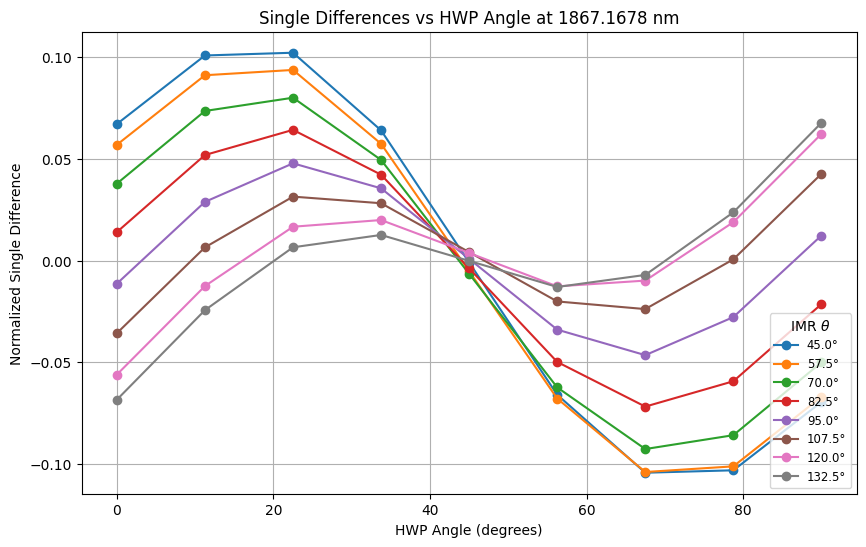

In [93]:
# create plot 

plot_single_differences(csv_path)